In [71]:
## read the data
import scipy.io
data = scipy.io.loadmat('/Users/jinyanwei/Desktop/BP_Model/Data/Cuffless_BP_Estimation/part_1.mat')

In [72]:
fs =125 # Sample rate in Hz
bp_standard_rate = 200

import numpy as np
def straighten_ecg(ecg_signal):
    detrended_ecg = np.subtract(ecg_signal, np.mean(ecg_signal))
    return detrended_ecg
    
import numpy as np
def normalize_sinal(ppg):
# Assuming ppg_signal and ecg_signal are your original PPG and ECG signals
    ppg_min = np.min(ppg)
    ppg_max = np.max(ppg)
    normalized_ppg = (ppg - ppg_min) / (ppg_max - ppg_min)
    return normalized_ppg
def standard_signal(bp): 
    return (bp - np.mean(bp)) / np.std(bp)
def inverse_standard_signal(bp_ori, bp_est):
    mean = np.mean(bp_ori)
    std = np.std(bp_ori)
    return (bp_est * std) + mean

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
def align_ppgbp_segment(ppg_signal, bp_signal1, bp_signal2, ecg_signal, show=0): ## ppg_signal = ppg_normalized, bp_signal = bp_normalized, ecg_signal = ecg_normalized; get ppg_aligned, bp_aligned
    ppg_peaks, _ = find_peaks(ppg_signal, height=0.5)  # Adjust the height threshold as needed
    bp_peaks, _ = find_peaks(bp_signal1, height=0.4)
    ecg_peaks, _ = find_peaks(ecg_signal, height=0.65)
    #print(f'ppg peaks: {len(ppg_peaks)} {ppg_peaks}')
    #print(f'ecg peaks: {len(ecg_peaks)} {ecg_peaks}')

    first_ecg_peak = ecg_peaks[0]
    #print(f'first ecg peak: {first_ecg_peak}')
    indices_ppg = np.argwhere(ppg_peaks[:10] > first_ecg_peak)
    first_ppg_peak = ppg_peaks[int(indices_ppg[0])]
    #print(f'first ppg peak: {first_ppg_peak}')
    indices_bp = np.argwhere(bp_peaks[:10] > first_ecg_peak)
    first_bp_peak = bp_peaks[int(indices_bp[0])]
    #print(f'first bp peak: {first_bp_peak}')
    ppg_bp_peaks_subtraction = abs(bp_peaks[int(indices_bp[0]):int(indices_bp[0])+20] - ppg_peaks[int(indices_ppg[0]):int(indices_ppg[0])+20])
    #print(ppg_bp_peaks_subtraction)
    distance_ppgbp = np.bincount(ppg_bp_peaks_subtraction).argmax()
    #print(move_distance)
    #print(bp_peaks[int(indices_bp[0]):int(indices_bp[0])+20] - ppg_peaks[int(indices_ppg[0]):int(indices_ppg[0])+20])
    #print(f'distance:{distance_ppgbp}')
    if first_bp_peak > first_ppg_peak:
        bp_aligned = bp_signal1[distance_ppgbp:]
        bp_ori_aligned = bp_signal2[distance_ppgbp:]
        ppg_aligned = ppg_signal
    elif first_bp_peak < first_ppg_peak:
        bp_aligned = bp_signal1
        bp_ori_aligned = bp_signal2
        ppg_aligned = ppg_signal[distance_ppgbp:]
    else:
        bp_aligned = bp_signal1
        bp_ori_aligned = bp_signal2
        ppg_aligned = ppg_signal
    #print(f'ppg len: {len(ppg_aligned)}')
    #print(f'bp len: {len(bp_aligned)}')
    min_len = min(len(bp_aligned), len(ppg_aligned))
    ppg_aligned = ppg_aligned[:min_len]
    bp_aligned = bp_aligned[:min_len]
    bp_ori_aligned = bp_ori_aligned[:min_len]
    ecg_aligned = ecg_signal[:min_len]
    #print(ecg_aligned)
    ppg_segmented = ppg_aligned[:first_ecg_peak-5]
    bp_segmented = bp_aligned[:first_ecg_peak-5]
    bp_ori_segmented = bp_ori_aligned[:first_ecg_peak-5]
    ecg_segmented = ecg_aligned[:first_ecg_peak-5]

    for ecgi in range(len(ecg_peaks)-1):
        one_ppg_peak, _ = find_peaks(ppg_aligned[ecg_peaks[ecgi]-5:ecg_peaks[ecgi + 1]-5], height=0.5)
        #print(ecg_peaks[ecgi], one_ppg_peak)
        if len(one_ppg_peak) == 1:
            ppg_segmented = np.concatenate((ppg_segmented, ppg_aligned[ecg_peaks[ecgi]-5:ecg_peaks[ecgi + 1]-5]))
            bp_segmented = np.concatenate((bp_segmented, bp_aligned[ecg_peaks[ecgi]-5:ecg_peaks[ecgi + 1]-5]))
            bp_ori_segmented = np.concatenate((bp_ori_segmented, bp_ori_aligned[ecg_peaks[ecgi]-5:ecg_peaks[ecgi + 1]-5]))
            ecg_segmented = np.concatenate((ecg_segmented, ecg_aligned[ecg_peaks[ecgi]-5:ecg_peaks[ecgi + 1]-5]))

    if show == 1:
        plt.figure(figsize=(30, 6))
        plt.plot(ppg_signal, label='PPG')
        plt.plot(bp_signal1, label='BP')
        plt.plot(ecg_signal, label='ECG')
        plt.scatter(ppg_peaks, ppg_signal[ppg_peaks], color='c', marker='o', label='Aligned PPG Peaks')
        plt.scatter(bp_peaks, bp_signal1[bp_peaks], color='orange', marker='o', label='Aligned BP Peaks')
        plt.scatter(ecg_peaks, ecg_signal[ecg_peaks], color='green', marker='o', label='Aligned BP Peaks')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.show()

        plt.figure(figsize=(30, 6))
        plt.plot(ppg_segmented, label='PPG')
        plt.plot(bp_segmented, label='BP')
        plt.plot(ecg_segmented, label='ECG')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.show()

    return ppg_segmented, bp_segmented, bp_ori_segmented, ecg_segmented

import numpy as np
def get_feautres(ppg_signal, bp_signal1, bp_signal2, ecg_signal):
    ori_ecg_peaks, _ = find_peaks(ecg_signal)
    r_peaks = np.array([ecg_peak for ecg_peak in ori_ecg_peaks if ecg_signal[ecg_peak] > 0.65])
    #print(f'r_peaks: {len(r_peaks)} {r_peaks}')
    r_peak_amplitudes = (ecg_signal[r_peaks]).tolist()
    r_peak_amplitudes = r_peak_amplitudes[:-1]
    #print(f'r_peak_amplitudes: {len(r_peak_amplitudes)} {r_peak_amplitudes}')
    r_peak_intervals = (np.diff(r_peaks) / fs).tolist()
    #print(f'r_peak_intervals: {len(r_peak_intervals)} {r_peak_intervals}')
    # calculate low peak, s-peak
    low_peak_amplitudes, r_to_low_peak_amplitudes, s_peak_amplitudes= [], [], []
    low_peaks, s_peaks = [], []
    for i in range(len(r_peaks) - 1):
        r_peak = r_peaks[i]
        next_r_peak = r_peaks[i + 1]
        low_peak_amplitude = np.min(ecg_signal[r_peak:next_r_peak])
        r_to_low_peak_amplitude = ecg_signal[r_peak]-low_peak_amplitude
        low_peak_amplitudes.append(low_peak_amplitude)
        r_to_low_peak_amplitudes.append(r_to_low_peak_amplitude)
        low_peak = r_peak + np.argmin(ecg_signal[r_peak:next_r_peak])
        low_peaks.append(low_peak)
        s_peak_amplitude = np.min(ecg_signal[r_peak:low_peak])
        s_peak_amplitudes.append(s_peak_amplitude)
        s_peak = r_peak + np.argmin(ecg_signal[r_peak:low_peak])
        s_peaks.append(s_peak)   
    #print(f'low peaks: {len(low_peaks)} {low_peaks}')  
    #print(f's peaks: {len(s_peaks)} {s_peaks}')  
    # T-Wave Amplitude Calculation
    r_peaks = np.insert(r_peaks, 0, 0) #the first t-peak is before the R-peak
    t_wave_amplitudes, q_wave_amplitudes = [], []
    t_peaks, q_peaks = [], []
    for i in range(len(r_peaks) - 1):
        r_peak = r_peaks[i]
        next_r_peak = r_peaks[i + 1]
        t_wave_amplitude = np.max(ecg_signal[r_peak:next_r_peak])
        t_wave_amplitudes.append(t_wave_amplitude)
        t_peak = r_peak + np.argmax(ecg_signal[r_peak:next_r_peak])
        t_peaks.append(t_peak)
        q_wave_amplitude = np.min(ecg_signal[t_peak:next_r_peak])
        q_wave_amplitudes.append(q_wave_amplitude)
        q_peak = r_peak + np.argmin(ecg_signal[t_peak:next_r_peak])
        q_peaks.append(q_peak)

    t_wave_amplitudes = t_wave_amplitudes[:-1]
    q_wave_amplitudes = q_wave_amplitudes[:-1]
    #print(f't peaks: {len(t_peaks)} {t_peaks}')  
    #print(f'q peaks: {len(q_peaks)} {q_peaks}')  
    
    # QRS interval
    r_peaks = np.array([ecg_peak for ecg_peak in ori_ecg_peaks if ecg_signal[ecg_peak] > 0.65])
    qrs_intervals = []
    for i in range(len(r_peaks)-1):
        qrs_interval = (ecg_signal[s_peaks[i]] - ecg_signal[q_peaks[i]]) / fs
        qrs_intervals.append(abs(qrs_interval))
    #print(f'qrs_intervals: {len(qrs_intervals)} {qrs_intervals}')  

    # get ppg features:
    ppg_pulses, bp_pulses, bp_ori_pulses = [], [], []
    for i in range(len(r_peaks)-1):
        ppg_pulse = ppg_signal[r_peaks[i]:r_peaks[i+1]]
        bp_pulse = bp_signal1[r_peaks[i]:r_peaks[i+1]]
        bp_ori_pulse = bp_signal2[r_peaks[i]:r_peaks[i+1]]
        ppg_pulses.append(ppg_pulse)
        bp_pulses.append(bp_pulse)
        bp_ori_pulses.append(bp_ori_pulse)
    #print(f'bp pulses: {bp_pulses}')
    ppg_pulse_amplitude = [np.max(pulse) - np.min(pulse) for pulse in ppg_pulses]
    ppg_pulse_width = [pulse.shape[0]/fs for pulse in ppg_pulses]
    ppg_high_to_low_interval = [np.argmin(pulse)/fs for pulse in ppg_pulses]
    ppg_slope_change_std = [np.std(np.diff(pulse)) for pulse in ppg_pulses]

    sbp = [np.max(pulse) for pulse in bp_pulses]
    dbp = [np.min(pulse) for pulse in bp_pulses]
    sbp_ori = [np.max(pulse) for pulse in bp_ori_pulses]
    dbp_ori = [np.min(pulse) for pulse in bp_ori_pulses]
    
    return sbp, dbp, sbp_ori, dbp_ori, ppg_pulse_amplitude, ppg_pulse_width, ppg_high_to_low_interval, ppg_slope_change_std, t_wave_amplitudes, q_wave_amplitudes, r_peak_amplitudes, s_peak_amplitudes, low_peak_amplitudes, qrs_intervals, r_to_low_peak_amplitudes, r_peak_intervals

import matplotlib.pyplot as plt
def show_one(signal1):
    fig = plt.figure(figsize=(30,6))
    plt.plot(signal1)
    return plt.show()
def show_two(signal1, signal2):
    fig = plt.figure(figsize=(30,6))
    plt.plot(signal1, label='1')
    plt.plot(signal2, label='2')
    plt.legend()
    return plt.show()
def show_three(signal1, signal2, signal3):
    fig = plt.figure(figsize=(30,6))
    plt.plot(signal1, label='1')
    plt.plot(signal2, label='2')
    plt.plot(signal3, label='3')
    plt.legend()
    return plt.show()

In [86]:
patient_data = data['p'][0,0][:,:3000]
ppg_ori = patient_data[0]
bp_ori = patient_data[1]
ecg_ori = patient_data[2]
ecg_detrened = straighten_ecg(ecg_ori)
ppg_normalized = normalize_sinal(ppg_ori)
bp_standarded = bp_ori / np.max(bp_ori)
ecg_normalized = normalize_sinal(ecg_detrened)
show_three(ppg_normalized, bp_standarded, ecg_normalized)

In [83]:
i = 0
np.argmin(ppg_signal[ppg_max_index[i]:ppg_max_index[i+1]])
ppg_max_index[i]

21

In [87]:
#def get_ppg_points_index(ppg_signal):
ppg_signal = patient_data[0]
ppg_min_index = []
ppg_max_index = []
ppg_height= (0.5 * (np.max(ppg_signal) - np.min(ppg_signal))) + np.min(ppg_signal)
for i in range(1, (len(ppg_signal)-1)):
    if (ppg_signal[i] > ppg_signal[i-1]) and (ppg_signal[i] >= ppg_signal[i+1]) and (ppg_signal[i] > ppg_height) :
        ppg_max_index.append(i)
for i in range(len(ppg_max_index[:-1])):
    ppg_min_index.append(ppg_max_index[i] + np.argmin(ppg_signal[ppg_max_index[i]:ppg_max_index[i+1]]))
print(f'{len(ppg_max_index)} ppg max index: {ppg_max_index}, \n{len(ppg_min_index)} ppg min index: {ppg_min_index}')

ppg_max_slopes_index = []
for i in range(len(ppg_min_index)):  
    ppg_segement = ppg_signal[ppg_min_index[i]:ppg_max_index[i+1]]
    ppg_slope_list = []
    for point in range(len(ppg_segement)-1):
        ppg_slope_list.append(ppg_segement[point+1]-ppg_segement[point])
    #print(i)
    #print(ppg_slope_list)
    ppg_max_slope = max(ppg_slope_list)
    ppg_max_slope_index_in_segement = ppg_slope_list.index(ppg_max_slope)
    ppg_max_slope_index = ppg_min_index[i] + ppg_max_slope_index_in_segement
    ppg_max_slopes_index.append(ppg_max_slope_index)
print(f'{len(ppg_max_slopes_index)} ppg max slope: {ppg_max_slopes_index}')
fig = plt.figure(figsize=(30,6))
plt.scatter(ppg_max_slopes_index, ppg_signal[ppg_max_slopes_index], color='orange', marker='o')
plt.scatter(ppg_max_index, ppg_signal[ppg_max_index], color='c', marker='o')
plt.scatter(ppg_min_index, ppg_signal[ppg_min_index], color='green', marker='o')
plt.plot(ppg_signal)
plt.show()

786 ppg max index: [21, 88, 153, 220, 286, 352, 418, 484, 551, 617, 683, 749, 815, 882, 912, 952, 1018, 1084, 1151, 1217, 1283, 1350, 1416, 1483, 1549, 1616, 1682, 1749, 1814, 1881, 1947, 2013, 2080, 2146, 2213, 2279, 2346, 2412, 2479, 2546, 2613, 2679, 2746, 2813, 2880, 2946, 3012, 3079, 3146, 3212, 3277, 3344, 3411, 3477, 3545, 3611, 3678, 3746, 3813, 3880, 3947, 4014, 4081, 4148, 4214, 4281, 4348, 4414, 4481, 4547, 4615, 4682, 4749, 4815, 4882, 4949, 5016, 5082, 5148, 5215, 5282, 5348, 5414, 5481, 5547, 5612, 5678, 5744, 5810, 5876, 5941, 6007, 6072, 6139, 6204, 6270, 6336, 6402, 6468, 6534, 6600, 6666, 6732, 6799, 6865, 6930, 6997, 7044, 7112, 7180, 7247, 7316, 7384, 7452, 7519, 7587, 7656, 7723, 7791, 7860, 7929, 7995, 8064, 8132, 8200, 8268, 8336, 8404, 8470, 8539, 8607, 8675, 8741, 8809, 8877, 8946, 9012, 9079, 9147, 9216, 9282, 9352, 9421, 9490, 9558, 9627, 9697, 9764, 9832, 9901, 9968, 10035, 10103, 10170, 10238, 10304, 10371, 10439, 10506, 10573, 10640, 10708, 10775, 10841, 1

ValueError: max() arg is an empty sequence

43 ppg max index: [14, 86, 130, 163, 233, 303, 374, 445, 514, 583, 723, 793, 862, 932, 1001, 1071, 1140, 1211, 1282, 1352, 1422, 1491, 1562, 1634, 1706, 1775, 1846, 1917, 1988, 2056, 2127, 2196, 2266, 2334, 2404, 2473, 2543, 2611, 2681, 2750, 2819, 2888, 2956], 
42 ppg min index: [69, 112, 147, 216, 287, 358, 428, 498, 567, 637, 775, 845, 915, 984, 1054, 1124, 1194, 1264, 1335, 1405, 1474, 1545, 1616, 1689, 1759, 1830, 1900, 1970, 2040, 2110, 2180, 2249, 2318, 2387, 2457, 2526, 2595, 2664, 2733, 2803, 2869, 2940]
42 ppg max slope: [77, 128, 153, 224, 294, 365, 435, 506, 574, 712, 783, 851, 922, 992, 1061, 1132, 1200, 1272, 1343, 1412, 1482, 1553, 1624, 1696, 1766, 1836, 1907, 1978, 2047, 2117, 2185, 2256, 2326, 2394, 2464, 2533, 2602, 2671, 2740, 2809, 2878, 2946]


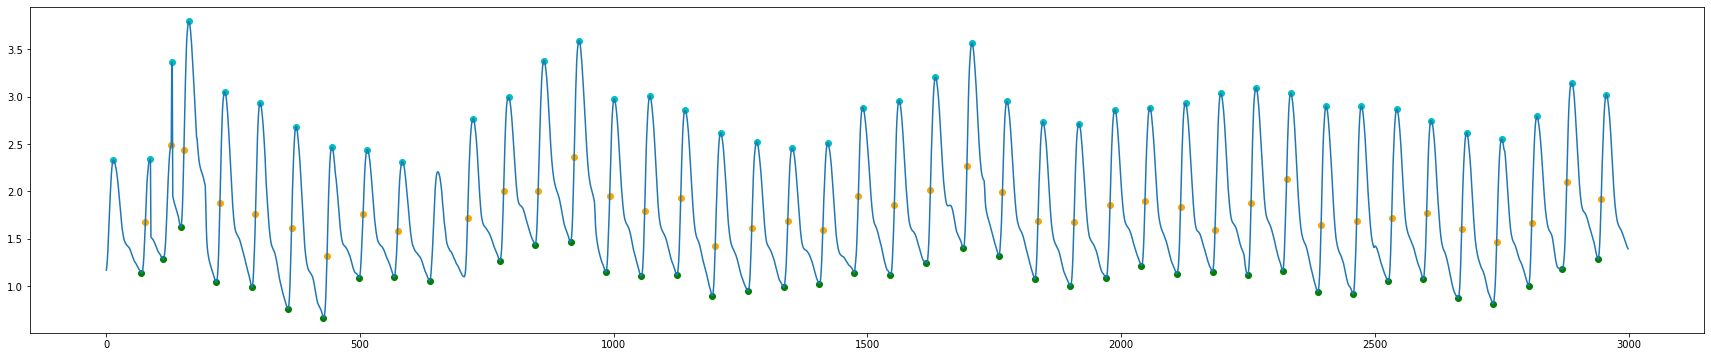

In [76]:
#def get_ppg_points_index(ppg_signal):
ppg_signal = patient_data[0]
ppg_min_index = []
ppg_max_index = []
ppg_height= (0.5 * (np.max(ppg_signal) - np.min(ppg_signal))) + np.min(ppg_signal)
for i in range(1, (len(ppg_signal)-1)):
    if (ppg_signal[i] > ppg_signal[i-1]) and (ppg_signal[i] >= ppg_signal[i+1]) and (ppg_signal[i] > ppg_height) :
        ppg_max_index.append(i)
for i in range(len(ppg_max_index[:-1])):
    ppg_min_index.append(ppg_max_index[i] + np.argmin(ppg_signal[ppg_max_index[i]:ppg_max_index[i+1]]))
print(f'{len(ppg_max_index)} ppg max index: {ppg_max_index}, \n{len(ppg_min_index)} ppg min index: {ppg_min_index}')

ppg_max_slopes_index = []
for i in range(len(ppg_min_index)):  
    ppg_segement = ppg_signal[ppg_min_index[i]:ppg_max_index[i+1]]
    ppg_slope_list = []
    for point in range(len(ppg_segement)-1):
        ppg_slope_list.append(ppg_segement[point+1]-ppg_segement[point])
    #print(i)
    #print(ppg_slope_list)
    ppg_max_slope = max(ppg_slope_list)
    ppg_max_slope_index_in_segement = ppg_slope_list.index(ppg_max_slope)
    ppg_max_slope_index = ppg_min_index[i] + ppg_max_slope_index_in_segement
    ppg_max_slopes_index.append(ppg_max_slope_index)
print(f'{len(ppg_max_slopes_index)} ppg max slope: {ppg_max_slopes_index}')
fig = plt.figure(figsize=(30,6))
plt.scatter(ppg_max_slopes_index, ppg_signal[ppg_max_slopes_index], color='orange', marker='o')
plt.scatter(ppg_max_index, ppg_signal[ppg_max_index], color='c', marker='o')
plt.scatter(ppg_min_index, ppg_signal[ppg_min_index], color='green', marker='o')
plt.plot(ppg_signal)
plt.show()

722 sbp index: [189, 255, 453, 520, 586, 784, 851, 986, 1053, 1319, 1584, 1651, 1849, 1916, 2182, 2248, 2448, 2515, 2782, 3114, 3379, 3446, 3646, 3714, 3982, 4049, 4249, 4316, 4583, 5777, 5843, 6105, 6171, 6369, 6434, 6699, 6765, 7013, 7081, 7149, 7216, 7284, 7352, 7420, 7487, 7555, 7623, 7691, 7760, 7829, 7898, 7964, 8034, 8102, 8169, 8236, 8304, 8373, 8440, 8507, 8576, 8647, 8710, 8777, 8845, 8913, 8981, 9048, 9116, 9119, 9124, 9184, 9251, 9320, 9389, 9457, 9526, 9596, 9665, 9732, 9801, 9869, 9937, 10004, 10071, 10138, 10205, 10272, 10340, 10407, 10474, 10541, 10608, 10675, 10743, 10809, 10877, 10945, 11011, 11078, 11145, 11213, 11280, 11347, 11416, 11483, 11550, 11618, 11686, 11752, 11820, 11879, 11891, 11956, 12033, 12096, 12162, 12227, 12292, 12355, 12421, 12486, 12550, 12616, 12680, 12738, 12747, 12811, 12872, 12937, 12999, 13016, 13081, 13146, 13211, 13275, 13340, 13406, 13471, 13537, 13604, 13670, 13736, 13803, 13870, 13938, 14005, 14071, 14140, 14205, 14272, 14337, 14404, 1446

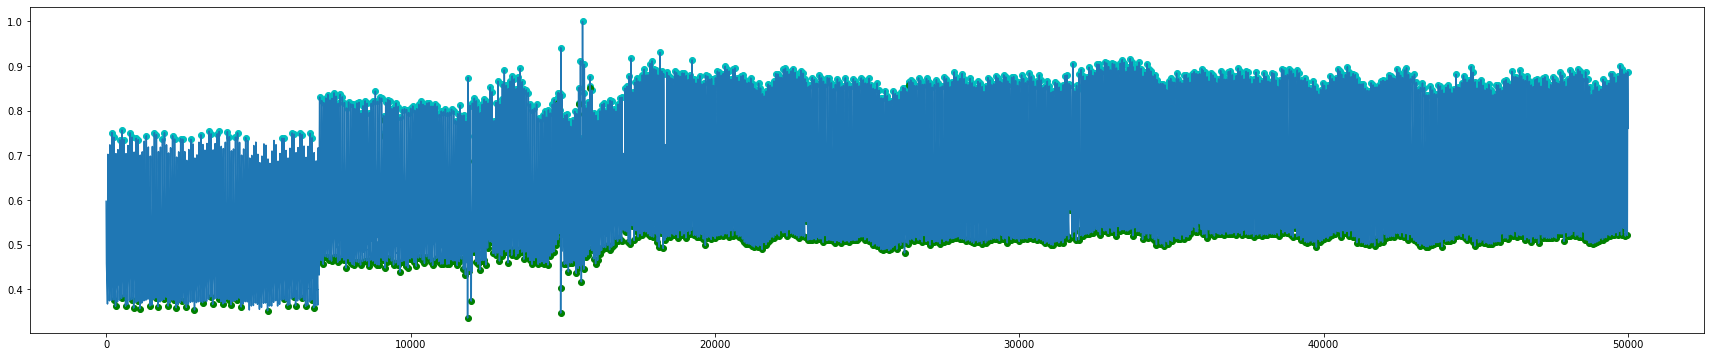

In [88]:
#def get_bp_points_index(bp_signal):
bp_signal = patient_data[1] / np.max(patient_data[1])
sbp_height = np.min(bp_signal) + 0.6 * (np.max(bp_signal) - np.min(bp_signal))
sbp_index = []
for i in range(1, (len(bp_signal)-1)):
    if (bp_signal[i] > bp_signal[i-1]) and (bp_signal[i] >= bp_signal[i+1]) and (bp_signal[i] > sbp_height):
        sbp_index.append(i)

dbp_index = []
for index_one, index_two in zip(sbp_index[:-1], sbp_index[1:]):
    dbp_index.append(np.argmin(bp_signal[index_one:index_two]) + index_one)

print(f'{len(sbp_index)} sbp index: {sbp_index}, \n{len(dbp_index)} dbp index: {dbp_index}')
fig = plt.figure(figsize=(30,6))
plt.scatter(sbp_index, bp_signal[sbp_index], color='c', marker='o')
plt.scatter(dbp_index, bp_signal[dbp_index], color='green', marker='o')
plt.plot(bp_signal)
plt.show()

0.6812316715542521
45 r peak index: [19, 85, 151, 218, 284, 349, 416, 482, 549, 614, 680, 747, 813, 880, 949, 1015, 1082, 1148, 1215, 1281, 1348, 1414, 1480, 1547, 1613, 1680, 1745, 1812, 1879, 1945, 2011, 2077, 2144, 2211, 2277, 2344, 2411, 2477, 2544, 2610, 2677, 2744, 2811, 2877, 2943]
44 ecg min index: [46, 111, 178, 244, 310, 376, 443, 509, 576, 641, 707, 774, 840, 906, 975, 1042, 1109, 1175, 1242, 1308, 1375, 1441, 1507, 1574, 1640, 1707, 1773, 1839, 1905, 1972, 2038, 2105, 2171, 2238, 2305, 2370, 2438, 2504, 2571, 2637, 2704, 2771, 2838, 2905]
44 s peak index: [22, 88, 155, 221, 287, 352, 419, 486, 552, 617, 683, 750, 817, 883, 952, 1019, 1085, 1151, 1218, 1285, 1351, 1417, 1483, 1550, 1617, 1683, 1748, 1815, 1882, 1949, 2014, 2081, 2148, 2214, 2280, 2347, 2414, 2481, 2548, 2613, 2680, 2748, 2814, 2881]
43 p peak index: [73, 140, 206, 272, 338, 404, 470, 537, 603, 668, 735, 801, 868, 937, 1004, 1070, 1137, 1203, 1270, 1336, 1402, 1469, 1535, 1602, 1668, 1734, 1800, 1867, 1933, 1

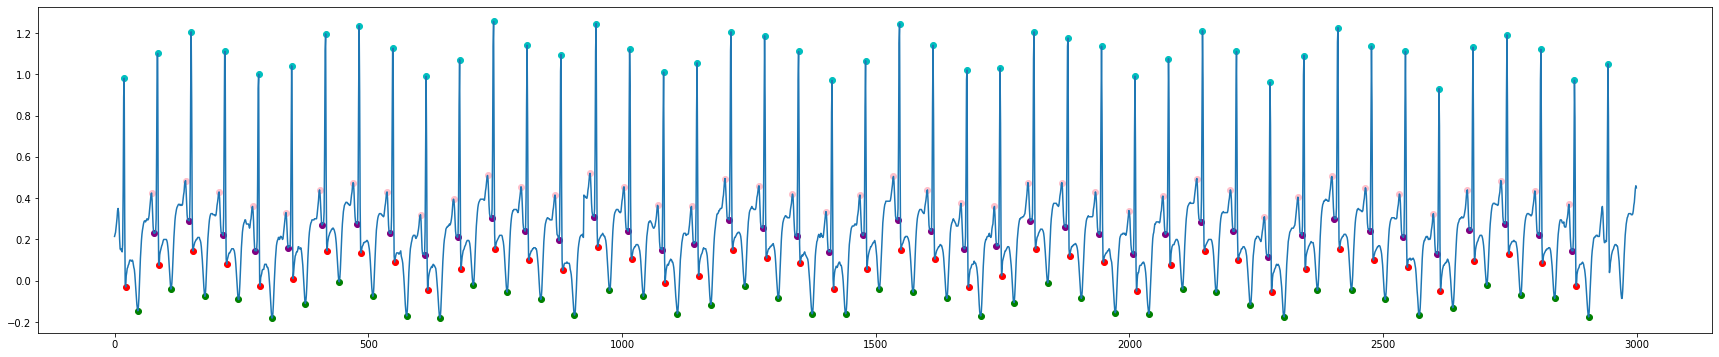

In [90]:
#def get_ecg_points_index(ecg_signal):
ecg_signal = patient_data[2][:3000]

ecg_r_height = min(ecg_signal) + ((max(ecg_signal) - min(ecg_signal)) * 0.6)
print(ecg_r_height)
r_peak_index = []
for i in range(1, (len(ecg_signal)-1)):
    if (ecg_signal[i] > ecg_signal[i-1]) and (ecg_signal[i] >= ecg_signal[i+1]) and (ecg_signal[i] >= ecg_r_height):
        r_peak_index.append(i)
print(f'{len(r_peak_index)} r peak index: {r_peak_index}')

ecg_min_index = []
for index0, index1 in zip(r_peak_index[:-1], r_peak_index[1:]):
    #print(f'index0: {index0}, index1: {index1}')
    ecg_min_index.append(index0 + np.argmin(ecg_signal[index0:index1]))
print(f'{len(ecg_min_index)} ecg min index: {ecg_min_index}')   

s_peak_index = []
for index0, index1 in zip(r_peak_index[:-1], ecg_min_index):
    ecg_second_half = ecg_signal[index0:index1]
    #s_peak_in_one_peak = []
    #s_peak_in_one_peak_index = []
    for i in range(1, len(ecg_second_half) - 1):
        if (ecg_second_half[i] < ecg_second_half[i - 1]) and (ecg_second_half[i] <= ecg_second_half[i + 1]):
            #s_peak_in_one_peak.append(ecg_second_half[i])
            #s_peak_in_one_peak_index.append(index0 + i)
            #s_peak_true = min(s_peak_in_one_peak)
            #s_peak_index.append(s_peak_in_one_peak_index[s_peak_in_one_peak.index(s_peak_true)])
            s_peak_index.append(index0 + i)
            break
print(f'{len(s_peak_index)} s peak index: {s_peak_index}')   

p_peak_index = []
for i in range(min(len(ecg_min_index),len(r_peak_index)) - 1):
    index_one = ecg_min_index[i]
    index_two = r_peak_index[i + 1]
    find_p_peak_list = []
    find_p_peak_index_list = []
    for i in range(index_one, index_two):
        if (ecg_signal[i] > ecg_signal[i - 1]) and (ecg_signal[i] > ecg_signal[i + 1]):
            find_p_peak_list.append(ecg_signal[i])
            find_p_peak_index_list.append(i)
    if len(find_p_peak_list) >= 1:
        p_peak_index.append(find_p_peak_index_list[find_p_peak_list.index(max(find_p_peak_list))])
print(f'{len(p_peak_index)} p peak index: {p_peak_index}')   

q_peak_index = []
r_loc = 0
for index_p in p_peak_index:
    for index_r in r_peak_index[r_loc:]:
        if index_r > index_p:
            q_peak_index.append(index_p + np.argmin(ecg_signal[index_p:index_r]))
            r_loc = r_peak_index.index(index_r)
            break
print(f'{len(q_peak_index)} q peak index: {q_peak_index}')

fig = plt.figure(figsize=(30,6))
plt.plot(ecg_signal)
plt.scatter(r_peak_index, ecg_signal[r_peak_index], color='c', marker='o')
plt.scatter(ecg_min_index, ecg_signal[ecg_min_index], color='green', marker='o')
plt.scatter(s_peak_index, ecg_signal[s_peak_index], color='red', marker='o')
plt.scatter(p_peak_index, ecg_signal[p_peak_index], color='pink', marker='o')
plt.scatter(q_peak_index, ecg_signal[q_peak_index], color='purple', marker='o')
plt.show()

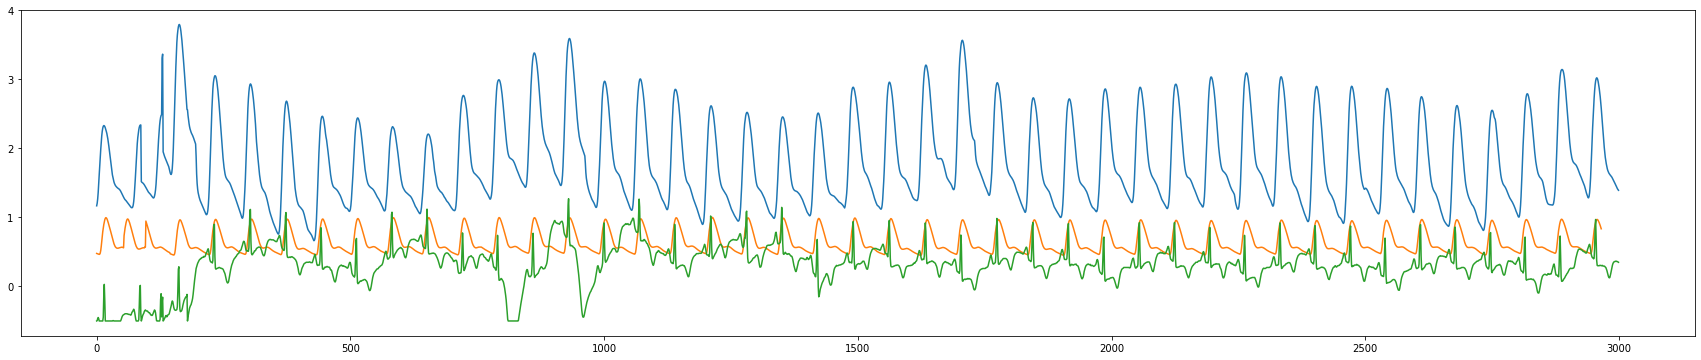

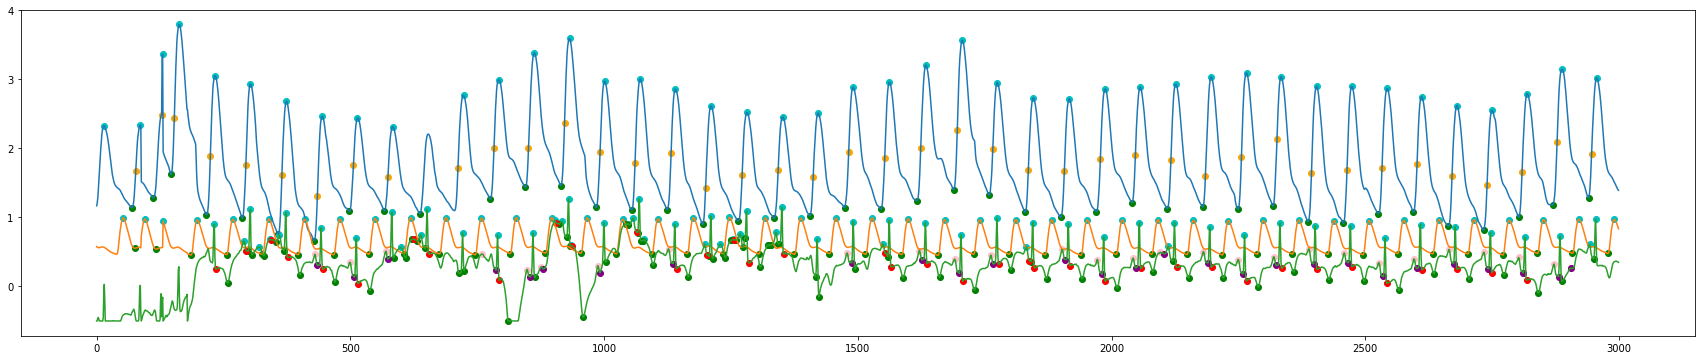

In [39]:
import random
for i in range(len(p_peak_index)-1):
    ppg_segement_in_ppeaks = ppg_signal[p_peak_index[i]:p_peak_index[i+1]]
    ppg_max_index_list = []
    bp_segement_in_ppeaks = bp_signal[p_peak_index[i]:p_peak_index[i+1]]
    sbp_index_list = []

    for ppg_index in ppg_max_index:
        if ppg_index < p_peak_index[i+1]:
            if ppg_index >p_peak_index[i]:
                ppg_max_index_list.append(ppg_index)
    for bp_index in sbp_index:
        if bp_index < p_peak_index[i+1]:
            if bp_index >p_peak_index[i]:
                sbp_index_list.append(bp_index)    
    #print(f'max ppg len: {len(ppg_max_index_list)}') 
    #print(f'sbp len: {len(sbp_index_list)}') 

    if len(ppg_max_index_list) == 1 and len(sbp_index_list) == 1:
        if sbp_index_list[0] >= ppg_max_index_list[0]:
            bp_signal_aligned_to_ppg = bp_signal[(sbp_index_list[0] - ppg_max_index_list[0]):]
            
        else:
            bp_random = [random.randint(0,1) for _ in range(abs(sbp_index_list[0] - ppg_max_index_list[0]))]
            bp_signal_aligned_to_ppg = bp_random + bp_signal
        break
fig = plt.figure(figsize =(30,6))
plt.plot(ppg_signal)
plt.plot(bp_signal_aligned_to_ppg)
plt.plot(ecg_signal)
plt.show()
fig = plt.figure(figsize=(30,6))

plt.plot(ppg_signal)
plt.scatter(ppg_max_slopes_index, ppg_signal[ppg_max_slopes_index], color='orange', marker='o')
plt.scatter(ppg_max_index, ppg_signal[ppg_max_index], color='c', marker='o')
plt.scatter(ppg_min_index, ppg_signal[ppg_min_index], color='green', marker='o')
plt.scatter(sbp_index, bp_signal[sbp_index], color='c', marker='o')
plt.scatter(dbp_index, bp_signal[dbp_index], color='green', marker='o')
plt.plot(bp_signal)
plt.plot(ecg_signal)
plt.scatter(r_peak_index, ecg_signal[r_peak_index], color='c', marker='o')
plt.scatter(ecg_min_index, ecg_signal[ecg_min_index], color='green', marker='o')
plt.scatter(s_peak_index, ecg_signal[s_peak_index], color='red', marker='o')
plt.scatter(p_peak_index, ecg_signal[p_peak_index], color='pink', marker='o')
plt.scatter(q_peak_index, ecg_signal[q_peak_index], color='purple', marker='o')
plt.show()

In [44]:
ppg_aligned = []
bp_aligned = []
ecg_aligned = []
'''for i in range(len(p_peak_index[:-1])):
    ppg_segement = ppg_signal[p_peak_index[i]:p_peak_index[i+1]]
    bp_segement = bp_signal_aligned_to_ppg[p_peak_index[i]:p_peak_index[i+1]]
    ecg_segement = ecg_signal[p_peak_index[i]:p_peak_index[i+1]]'''
ppg_max_index_aligned = []

begin_index = 0
window_index = 5
for p_index_one, p_index_two in zip(p_peak_index[:-1], p_peak_index[1:]):
    index_list = list(range(p_index_one, p_index_two))
    # print(index_list)
    for i in range(begin_index, (begin_index + window_index)):
        if ppg_max_index[i] in index_list:
            


            begin_index = ppg_max_index.index(i)



[430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498]


In [51]:
jywlist = list(range(10,15))
for i in range(len(jywlist)):
    jywlist[i] = jywlist[i] + 5
print(jywlist)
a = 13
if a in jywlist:
    print(a, jywlist.index(a))

[15, 16, 17, 18, 19]


In [ ]:
# get all patient dataset
patients = [0, 1, 2, 3, 4, 6, 14, 15, 16, 18, 24, 35, 36, 37, 39, 40, 41, 46, 64, 66, 67, 73, 79, 80, 81, 82, 86, 87, 88, 89, 93, 94, 95, 98, 99, 100, 101, 102, 103, 104, 105, 108, 109, 110, 111, 115, 116, 117, 118, 120, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 141, 144, 149, 150, 151, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 179, 182, 184, 186, 188, 189, 192, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 206, 207, 208, 209, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 245, 246, 247, 248, 249, 251, 252, 253, 254, 255, 256, 257, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 272, 273, 277, 278, 279, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 295, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 309, 310, 311, 313, 314, 315, 316, 317, 318, 319, 320, 321, 323, 324, 327, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 377, 380, 391, 393, 394, 395, 397, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 413, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 429, 430, 431, 432, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 459, 460, 462, 463, 464, 465, 466, 470, 471, 472, 475, 480, 481, 482, 483, 484, 486, 487, 488, 490, 491, 492, 496, 497, 498, 499, 500, 502, 503, 504, 505, 507, 508, 509, 510, 512, 514, 515, 516, 520, 524, 527, 528, 529, 530, 531, 532, 533, 535, 537, 538, 539, 543, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 564, 565, 570, 576, 577, 578, 582, 590, 592, 593, 597, 599, 600, 602, 603, 604, 606, 607, 609, 612, 625, 626, 627, 628, 629, 630, 633, 634, 635, 639, 640, 641, 644, 646, 648, 653, 655, 656, 657, 658, 662, 670, 673, 674, 676, 677, 681, 682, 683, 685, 686, 687, 688, 689, 692, 693, 695, 696, 697, 698, 700, 703, 704, 705, 706, 707, 708, 709, 711, 712, 717, 719, 720, 721, 722, 723, 724, 725, 727, 729, 730, 731, 733, 734, 735, 736, 737, 741, 743, 744, 748, 749, 753, 754, 755, 756, 759, 774, 775, 776, 777, 780, 781, 783, 784, 785, 786, 787, 790, 791, 792, 794, 799, 800, 801, 802, 803, 805, 807, 808, 809, 810, 813, 820, 821, 822, 823, 828, 829, 830, 843, 845, 847, 868, 869, 922, 923, 947, 948, 949, 951, 952, 957, 959, 960, 962, 972, 975, 981, 989]
sbp500 = []
dbp500 = []
sbp_ori500 = []
dbp_ori500 = []
features500 = []
for patient in patients[:3]:
    patient_data = data['p'][0,patient]
    if len(patient_data[0]) >= 25000:
        ppg_ori = patient_data[0]
        bp_ori = patient_data[1]
        ecg_ori = patient_data[2]
        ecg_detrened = straighten_ecg(ecg_ori)
        ppg_normalized = normalize_sinal(ppg_ori)
        bp_standarded = bp_ori / bp_standard_rate
        ecg_normalized = normalize_sinal(ecg_detrened)
        ppg_segmented, bp_segmented, bp_ori_segmented, ecg_segmented = align_ppgbp_segment(ppg_signal = ppg_normalized, bp_signal1 = bp_standarded, bp_signal2 = bp_ori, ecg_signal = ecg_normalized, show=0)
        bps_features = get_feautres(ppg_segmented, bp_segmented, bp_ori_segmented, ecg_segmented)
        sbp = np.array(bps_features[0])
        dbp = np.array(bps_features[1])
        sbp_ori = np.array(bps_features[2])
        dbp_ori = np.array(bps_features[3])
        features = np.array(bps_features[4:])
        sbp500.append(sbp)
        dbp500.append(dbp)
        sbp_ori500.append(sbp_ori)
        dbp_ori500.append(dbp_ori)
        features500.append(features)
        #print(patient)
#len(sbp_ori500)    